In [5]:
from dataclasses import dataclass
import torch
import torchaudio
import IPython
import matplotlib.pyplot as plt

torch.random.manual_seed(0)

SPEECH_FILE = "/ssd_scratch/cvit/kolubex/.cache/gsoc/peoples_speech_samples/2.wav"

In [7]:
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = bundle.get_model().to(device)
labels = bundle.get_labels()
with torch.inference_mode():
    waveform, _ = torchaudio.load(SPEECH_FILE)
    emissions, _ = model(waveform.to(device))
    emissions = torch.log_softmax(emissions, dim=-1)

emission = emissions[0].cpu().detach()

print(labels)

('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


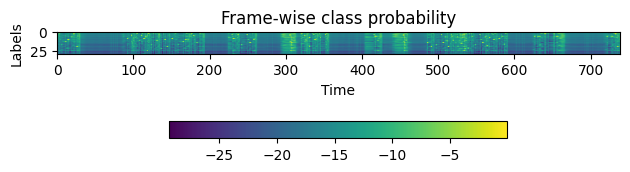

In [8]:
def plot():
    fig, ax = plt.subplots()
    img = ax.imshow(emission.T)
    ax.set_title("Frame-wise class probability")
    ax.set_xlabel("Time")
    ax.set_ylabel("Labels")
    fig.colorbar(img, ax=ax, shrink=0.6, location="bottom")
    fig.tight_layout()


plot()

In [15]:
# We enclose the transcript with space tokens, which represent SOS and EOS.
transcript = "|SECURITY|SO|IT|DOESN'T|FEEL|VERY|SECURE|TO|ME|AS|A|FARMER|TO|HEAR|THAT|AND|MY|FAMILY|AND|I|WE'VE|BEEN|FARMING|HERE|SINCE|NINETEEN|NINETY|"
dictionary = {c: i for i, c in enumerate(labels)}

tokens = [dictionary[c] for c in transcript]
print(list(zip(transcript, tokens)))


def get_trellis(emission, tokens, blank_id=0):
    num_frame = emission.size(0)
    num_tokens = len(tokens)

    trellis = torch.zeros((num_frame, num_tokens))
    trellis[1:, 0] = torch.cumsum(emission[1:, blank_id], 0)
    trellis[0, 1:] = -float("inf")
    trellis[-num_tokens + 1 :, 0] = float("inf")

    for t in range(num_frame - 1):
        trellis[t + 1, 1:] = torch.maximum(
            # Score for staying at the same token
            trellis[t, 1:] + emission[t, blank_id],
            # Score for changing to the next token
            trellis[t, :-1] + emission[t, tokens[1:]],
        )
    return trellis


trellis = get_trellis(emission, tokens)

[('|', 1), ('S', 9), ('E', 2), ('C', 16), ('U', 13), ('R', 10), ('I', 7), ('T', 3), ('Y', 19), ('|', 1), ('S', 9), ('O', 5), ('|', 1), ('I', 7), ('T', 3), ('|', 1), ('D', 11), ('O', 5), ('E', 2), ('S', 9), ('N', 6), ("'", 24), ('T', 3), ('|', 1), ('F', 17), ('E', 2), ('E', 2), ('L', 12), ('|', 1), ('V', 22), ('E', 2), ('R', 10), ('Y', 19), ('|', 1), ('S', 9), ('E', 2), ('C', 16), ('U', 13), ('R', 10), ('E', 2), ('|', 1), ('T', 3), ('O', 5), ('|', 1), ('M', 14), ('E', 2), ('|', 1), ('A', 4), ('S', 9), ('|', 1), ('A', 4), ('|', 1), ('F', 17), ('A', 4), ('R', 10), ('M', 14), ('E', 2), ('R', 10), ('|', 1), ('T', 3), ('O', 5), ('|', 1), ('H', 8), ('E', 2), ('A', 4), ('R', 10), ('|', 1), ('T', 3), ('H', 8), ('A', 4), ('T', 3), ('|', 1), ('A', 4), ('N', 6), ('D', 11), ('|', 1), ('M', 14), ('Y', 19), ('|', 1), ('F', 17), ('A', 4), ('M', 14), ('I', 7), ('L', 12), ('Y', 19), ('|', 1), ('A', 4), ('N', 6), ('D', 11), ('|', 1), ('I', 7), ('|', 1), ('W', 15), ('E', 2), ("'", 24), ('V', 22), ('E', 2)

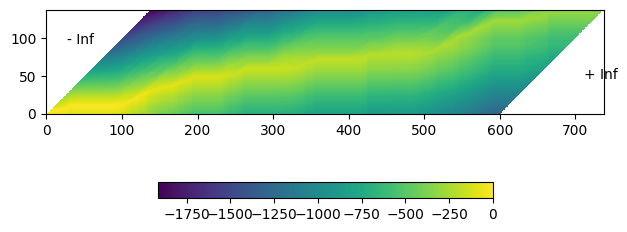

In [16]:
def plot():
    fig, ax = plt.subplots()
    img = ax.imshow(trellis.T, origin="lower")
    ax.annotate("- Inf", (trellis.size(1) / 5, trellis.size(1) / 1.5))
    ax.annotate("+ Inf", (trellis.size(0) - trellis.size(1) / 5, trellis.size(1) / 3))
    fig.colorbar(img, ax=ax, shrink=0.6, location="bottom")
    fig.tight_layout()


plot()

In [17]:
@dataclass
class Point:
    token_index: int
    time_index: int
    score: float


def backtrack(trellis, emission, tokens, blank_id=0):
    t, j = trellis.size(0) - 1, trellis.size(1) - 1

    path = [Point(j, t, emission[t, blank_id].exp().item())]
    while j > 0:
        # Should not happen but just in case
        assert t > 0

        # 1. Figure out if the current position was stay or change
        # Frame-wise score of stay vs change
        p_stay = emission[t - 1, blank_id]
        p_change = emission[t - 1, tokens[j]]

        # Context-aware score for stay vs change
        stayed = trellis[t - 1, j] + p_stay
        changed = trellis[t - 1, j - 1] + p_change

        # Update position
        t -= 1
        if changed > stayed:
            j -= 1

        # Store the path with frame-wise probability.
        prob = (p_change if changed > stayed else p_stay).exp().item()
        path.append(Point(j, t, prob))

    # Now j == 0, which means, it reached the SoS.
    # Fill up the rest for the sake of visualization
    while t > 0:
        prob = emission[t - 1, blank_id].exp().item()
        path.append(Point(j, t - 1, prob))
        t -= 1

    return path[::-1]


path = backtrack(trellis, emission, tokens)
for p in path:
    print(p)

Point(token_index=0, time_index=0, score=0.9997172951698303)
Point(token_index=1, time_index=1, score=0.9999731779098511)
Point(token_index=1, time_index=2, score=0.9982998967170715)
Point(token_index=2, time_index=3, score=0.2211674153804779)
Point(token_index=2, time_index=4, score=0.9995415210723877)
Point(token_index=2, time_index=5, score=0.9992160797119141)
Point(token_index=2, time_index=6, score=0.9997336268424988)
Point(token_index=3, time_index=7, score=0.9999847412109375)
Point(token_index=3, time_index=8, score=0.9999884366989136)
Point(token_index=3, time_index=9, score=0.9999880790710449)
Point(token_index=3, time_index=10, score=0.9995575547218323)
Point(token_index=3, time_index=11, score=0.9989984631538391)
Point(token_index=4, time_index=12, score=0.996532678604126)
Point(token_index=4, time_index=13, score=0.9971247315406799)
Point(token_index=4, time_index=14, score=0.9993323683738708)
Point(token_index=5, time_index=15, score=0.012707045301795006)
Point(token_index

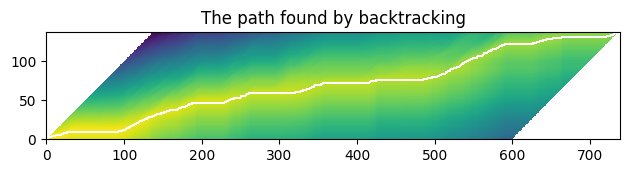

In [18]:
def plot_trellis_with_path(trellis, path):
    # To plot trellis with path, we take advantage of 'nan' value
    trellis_with_path = trellis.clone()
    for _, p in enumerate(path):
        trellis_with_path[p.time_index, p.token_index] = float("nan")
    plt.imshow(trellis_with_path.T, origin="lower")
    plt.title("The path found by backtracking")
    plt.tight_layout()


plot_trellis_with_path(trellis, path)

In [19]:
# Merge the labels
# YES
@dataclass
class Segment:
    label: str
    start: int
    end: int
    score: float

    def __repr__(self):
        return f"{self.label}\t({self.score:4.2f}): [{self.start:5d}, {self.end:5d})"

    @property
    def length(self):
        return self.end - self.start


def merge_repeats(path):
    i1, i2 = 0, 0
    segments = []
    while i1 < len(path):
        while i2 < len(path) and path[i1].token_index == path[i2].token_index:
            i2 += 1
        score = sum(path[k].score for k in range(i1, i2)) / (i2 - i1)
        segments.append(
            Segment(
                transcript[path[i1].token_index],
                path[i1].time_index,
                path[i2 - 1].time_index + 1,
                score,
            )
        )
        i1 = i2
    return segments


segments = merge_repeats(path)
for seg in segments:
    print(seg)

|	(1.00): [    0,     1)
S	(1.00): [    1,     3)
E	(0.80): [    3,     7)
C	(1.00): [    7,    12)
U	(1.00): [   12,    15)
R	(0.80): [   15,    20)
I	(0.91): [   20,    23)
T	(1.00): [   23,    27)
Y	(0.63): [   27,    30)
|	(0.98): [   30,    93)
S	(1.00): [   93,    98)
O	(0.92): [   98,   102)
|	(0.50): [  102,   104)
I	(1.00): [  104,   105)
T	(0.50): [  105,   107)
|	(0.65): [  107,   109)
D	(1.00): [  109,   111)
O	(0.60): [  111,   113)
E	(0.99): [  113,   114)
S	(0.67): [  114,   117)
N	(0.99): [  117,   119)
'	(1.00): [  119,   120)
T	(0.50): [  120,   122)
|	(0.81): [  122,   124)
F	(0.96): [  124,   127)
E	(1.00): [  127,   130)
E	(0.73): [  130,   132)
L	(0.50): [  132,   134)
|	(0.34): [  134,   137)
V	(1.00): [  137,   140)
E	(1.00): [  140,   142)
R	(0.76): [  142,   145)
Y	(0.66): [  145,   148)
|	(0.56): [  148,   152)
S	(1.00): [  152,   155)
E	(1.00): [  155,   159)
C	(1.00): [  159,   166)
U	(0.99): [  166,   169)
R	(0.76): [  169,   171)
E	(0.67): [  171,   174)


In [20]:
# Merge words
def merge_words(segments, separator="|"):
    words = []
    i1, i2 = 0, 0
    while i1 < len(segments):
        if i2 >= len(segments) or segments[i2].label == separator:
            if i1 != i2:
                segs = segments[i1:i2]
                word = "".join([seg.label for seg in segs])
                score = sum(seg.score * seg.length for seg in segs) / sum(seg.length for seg in segs)
                words.append(Segment(word, segments[i1].start, segments[i2 - 1].end, score))
            i1 = i2 + 1
            i2 = i1
        else:
            i2 += 1
    return words


word_segments = merge_words(segments)
for word in word_segments:
    print(word.start, word.end, word.label, word.score)

1 30 SECURITY 0.8899744571475633
93 102 SO 0.9631527993414137
104 107 IT 0.6683145278754333
109 122 DOESN'T 0.7833847335826319
124 134 FEEL 0.8334806433002087
137 148 VERY 0.8410134838618846
152 174 SECURE 0.9311605760488998
177 182 TO 0.8235923111438751
184 193 ME 0.7209502772524906
230 235 AS 0.6378832519054413
238 240 A 0.5071100685745478
242 261 FARMER 0.8484819179498836
321 328 TO 0.9347372225352696
331 342 HEAR 0.8254048775204204
345 356 THAT 0.9113424403423612
416 425 AND 0.6578053352884076
486 494 MY 0.9980808645486832
497 515 FAMILY 0.8507282820064574
517 521 AND 0.974899485707283
525 529 I 0.7899559438228607
531 538 WE'VE 0.7462585994175502
539 547 BEEN 0.8412978539709002
549 566 FARMING 0.9290409701711991
568 577 HERE 0.6784751367651753
580 590 SINCE 0.8618860572576523
627 664 NINETEEN 0.7609778256276488
722 738 NINETY 0.8111944122938439


0.020013531799729364 0.6004059539918809 SECURITY 0.8899744571475633
1.8612584573748308 2.041380243572395 SO 0.9631527993414137
2.0814073071718537 2.141447902571042 IT 0.6683145278754333
2.1814749661705006 2.4416508795669825 DOESN'T 0.7833847335826319
2.4816779431664413 2.6818132611637346 FEEL 0.8334806433002087
2.7418538565629227 2.9620027063599457 VERY 0.8410134838618846
3.0420568335588634 3.4823545331529093 SECURE 0.9311605760488998
3.5423951285520974 3.6424627875507443 TO 0.8235923111438751
3.682489851150203 3.8626116373477672 ME 0.7209502772524906
4.603112313937753 4.7031799729364 AS 0.6378832519054413
4.763220568335589 4.803247631935047 A 0.5071100685745478
4.843274695534506 5.223531799729364 FARMER 0.8484819179498836
6.424343707713126 6.564438430311231 TO 0.9347372225352696
6.62447902571042 6.844627875507443 HEAR 0.8254048775204204
6.90466847090663 7.124817320703653 THAT 0.9113424403423612
8.325629228687415 8.50575101488498 AND 0.6578053352884076
9.726576454668471 9.8866847090663

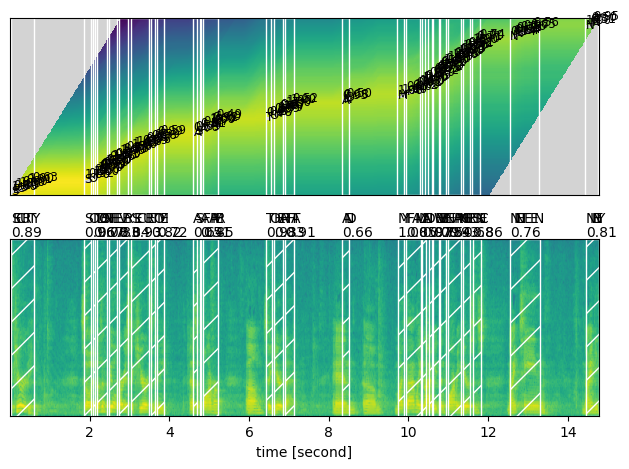

In [21]:
def plot_alignments(trellis, segments, word_segments, waveform, sample_rate=bundle.sample_rate):
    trellis_with_path = trellis.clone()
    for i, seg in enumerate(segments):
        if seg.label != "|":
            trellis_with_path[seg.start : seg.end, i] = float("nan")

    fig, [ax1, ax2] = plt.subplots(2, 1)

    ax1.imshow(trellis_with_path.T, origin="lower", aspect="auto")
    ax1.set_facecolor("lightgray")
    ax1.set_xticks([])
    ax1.set_yticks([])

    for word in word_segments:
        ax1.axvspan(word.start - 0.5, word.end - 0.5, edgecolor="white", facecolor="none")

    for i, seg in enumerate(segments):
        if seg.label != "|":
            ax1.annotate(seg.label, (seg.start, i - 0.7), size="small")
            ax1.annotate(f"{seg.score:.2f}", (seg.start, i + 3), size="small")

    # The original waveform
    ratio = waveform.size(0) / sample_rate / trellis.size(0)
    ax2.specgram(waveform, Fs=sample_rate)
    for word in word_segments:
        x0 = ratio * word.start
        x1 = ratio * word.end
        ax2.axvspan(x0, x1, facecolor="none", edgecolor="white", hatch="/")
        ax2.annotate(f"{word.score:.2f}", (x0, sample_rate * 0.51), annotation_clip=False)
        print(ratio * word.start, ratio * word.end, word.label, word.score)

    for seg in segments:
        if seg.label != "|":
            ax2.annotate(seg.label, (seg.start * ratio, sample_rate * 0.55), annotation_clip=False)

    ax2.set_xlabel("time [second]")
    ax2.set_yticks([])
    fig.tight_layout()


plot_alignments(
    trellis,
    segments,
    word_segments,
    waveform[0],
)